In [ ]:
### Scrapes Content and Starts From Checkpoint
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from webdriver_manager.chrome import ChromeDriverManager
import undetected_chromedriver as uc
import time
import pandas as pd
import random
import os
import json

# File paths and session folder
SESSION_DIR = os.path.join(os.getcwd(), "chrome_session")
os.makedirs(SESSION_DIR, exist_ok=True)
CHECKPOINT_FILE = "scraper_checkpoint.json"
PROGRESS_CSV = "businessday_progress3.csv"
FINAL_CSV = "businessday_final3.csv"

def remove_existing_files():
    """Remove existing progress and final CSV files for fresh start"""
    if os.path.exists(PROGRESS_CSV):
        os.remove(PROGRESS_CSV)
    if os.path.exists(FINAL_CSV):
        os.remove(FINAL_CSV)

def save_checkpoint(data):
    """Save current scraping state"""
    with open(CHECKPOINT_FILE, 'w') as f:
        json.dump(data, f)
    print(f"Checkpoint saved: Page {data['current_page']} | Articles: {data['articles_processed']}")

def load_checkpoint():
    """Load existing checkpoint if available"""
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'r') as f:
            data = json.load(f)
            print(f"Resuming from checkpoint: Page {data['current_page']}")
            return data
    return None

def setup_driver():
    """Configure undetected Chrome driver"""
    options = uc.ChromeOptions()
    options.add_argument(f"--user-data-dir={SESSION_DIR}")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36")
    driver = uc.Chrome(options=options)
    driver.set_page_load_timeout(30)
    return driver

def random_sleep(min=2, max=5):
    """Human-like random delay"""
    time.sleep(random.uniform(min, max))

def human_scroll(driver):
    """Realistic scrolling behavior"""
    total_height = driver.execute_script("return document.body.scrollHeight")
    current = 0
    while current < total_height:
        scroll = random.randint(300, 700)
        current += scroll
        driver.execute_script(f"window.scrollTo(0, {current});")
        random_sleep(0.5, 1.5)

def scrape_articles(driver, scraped_data):
    """Scrape article list with checkpoint support"""
    try:
        if "Just a moment" in driver.title:
            print("Cloudflare detected - waiting...")
            time.sleep(15)
            return False

        human_scroll(driver)
        container = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.news"))
        )
        articles = container.find_elements(By.CSS_SELECTOR, 'div.post-info')
        
        for item in articles:
            try:
                title_elem = item.find_element(By.CSS_SELECTOR, 'h2.post-title a')
                title = title_elem.text.strip()
                url = title_elem.get_attribute("href")
                
                # Skip duplicates
                if any(a['url'] == url for a in scraped_data):
                    continue
                
                # Get list page data
                author = item.find_element(By.CSS_SELECTOR, '.post-author a').text
                date = item.find_element(By.CLASS_NAME, 'post-date').text
                excerpt = item.find_element(By.CSS_SELECTOR, 'p').text
                
                scraped_data.append({
                    'title': title,
                    'author': author,
                    'date': date,
                    'excerpt': excerpt,
                    'url': url,
                    'content': None
                })
                print(f"Added: {title[:50]}...")
            except Exception as e:
                print(f"Article error: {e}")
        return True
    except Exception as e:
        print(f"Page error: {e}")
        return False

def scrape_content(driver, articles, start_index):
    """Scrape full content with checkpoint support"""
    for idx in range(start_index, len(articles)):
        article = articles[idx]
        try:
            driver.get(article['url'])
            WebDriverWait(driver, 15).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, ".post-content"))
            )
            content = driver.find_element(By.CSS_SELECTOR, ".post-content").text
            article['content'] = content.strip()
            print(f"Content scraped: {article['title'][:50]}...")
        except Exception as e:
            article['content'] = "Content unavailable"
            print(f"Content error: {e}")
        
        # Update checkpoint after each article
        save_checkpoint({
            'current_page': 'content',
            'articles_processed': idx + 1,
            'scraped_data': articles
        })
    return articles

def main():
    checkpoint = load_checkpoint()
    driver = setup_driver()
    
    # Initialize or resume state
    if checkpoint:
        scraped_data = checkpoint['scraped_data']
        current_page = checkpoint['current_page']
        articles_processed = checkpoint.get('articles_processed', 0)
    else:
        remove_existing_files()
        scraped_data = []
        current_page = 1
        articles_processed = 0

    max_pages = 820

    try:
        # Page scraping phase
        if isinstance(current_page, int) and current_page <= max_pages:
            if current_page == 1:
                driver.get('https://businessday.ng/tag/bdlead/?amp')
                random_sleep(3, 5)
            
            while current_page <= max_pages:
                print(f"\nScraping page {current_page}/{max_pages}")
                if scrape_articles(driver, scraped_data):
                    # Save page progress
                    save_checkpoint({
                        'current_page': current_page + 1,
                        'articles_processed': 0,
                        'scraped_data': scraped_data
                    })
                    pd.DataFrame(scraped_data).to_csv(PROGRESS_CSV, index=False)
                
                # Navigate to next page
                try:
                    next_btn = WebDriverWait(driver, 10).until(
                        EC.element_to_be_clickable((By.CSS_SELECTOR, 'a.next.page-numbers'))
                    )
                    driver.execute_script("arguments[0].click();", next_btn)
                    random_sleep(4, 7)
                    current_page += 1
                except:
                    current_page += 1  # Fallback to direct URL
                    driver.get(f"https://businessday.ng/tag/bdlead/page/{current_page}/")
                    random_sleep(4, 7)

        # Content scraping phase
        if current_page > max_pages or current_page == 'content':
            print("\nStarting content scraping...")
            scraped_data = scrape_content(driver, scraped_data, articles_processed)
            pd.DataFrame(scraped_data).to_csv(FINAL_CSV, index=False)
            if os.path.exists(CHECKPOINT_FILE):
                os.remove(CHECKPOINT_FILE)

    except KeyboardInterrupt:
        print("\nInterrupted by user. Checkpoint saved.")
    finally:
        driver.quit()
        if scraped_data and not os.path.exists(FINAL_CSV):
            pd.DataFrame(scraped_data).to_csv(FINAL_CSV, index=False)

if __name__ == "__main__":
    main()

Resuming from checkpoint: Page 715

Scraping page 715/820
Page error: Message: 
Stacktrace:
	GetHandleVerifier [0x010E8073+60707]
	GetHandleVerifier [0x010E80B4+60772]
	(No symbol) [0x00F10683]
	(No symbol) [0x00F58660]
	(No symbol) [0x00F589FB]
	(No symbol) [0x00FA1022]
	(No symbol) [0x00F7D094]
	(No symbol) [0x00F9E824]
	(No symbol) [0x00F7CE46]
	(No symbol) [0x00F4C5D3]
	(No symbol) [0x00F4D424]
	GetHandleVerifier [0x0132BB53+2435075]
	GetHandleVerifier [0x013270F3+2416035]
	GetHandleVerifier [0x0134349C+2531660]
	GetHandleVerifier [0x010FF145+155125]
	GetHandleVerifier [0x01105AED+182173]
	GetHandleVerifier [0x010EF948+91640]
	GetHandleVerifier [0x010EFAF0+92064]
	GetHandleVerifier [0x010DA5B0+4704]
	BaseThreadInitThunk [0x76337BA9+25]
	RtlInitializeExceptionChain [0x777FC2EB+107]
	RtlClearBits [0x777FC26F+191]


Scraping page 716/820
Cloudflare detected - waiting...

Scraping page 717/820
Cloudflare detected - waiting...

Scraping page 718/820
Added: The ugly face of Nigeria’s exp

In [3]:
df = pd.read_csv(r'C:\Users\DELL LATITUDE 7399\Desktop\DATA ANALYSIS\PYTHON\businessday_final301.csv')


In [4]:
df.head()  # Displays the first 5 rows of the dataframe


,Title,Author,Date,Excerpt,URL,Content
0,Oil palm growers to replant 1.5m hectares on r...,Iheanyi Nwachukwu,"Apr 16, 2025","…As BUA, OOP, others ramp up investments Oil p...",https://businessday.ng/news/article/oil-palm-g...,"…As BUA, OOP, others ramp up investments\nOil ..."
1,How CBEX wiped off investors’ N1.3trn in nine ...,Temitayo Jaiyeola,"Apr 16, 2025","Nigerians are no strangers to Ponzi schemes, w...",https://businessday.ng/technology/article/how-...,"Nigerians are no strangers to Ponzi schemes, w..."
2,Metering hits 4-year low as FG misses target,Abubakar Ibrahim,"Apr 16, 2025",Nigeria’s power sector is facing renewed scrut...,https://businessday.ng/energy/power/article/me...,Nigeria’s power sector is facing renewed scrut...
3,Investment Act opens window for digital asset ...,Wasiu Alli,"Apr 16, 2025",… Digital asset seen lifting naira’s value Nig...,https://businessday.ng/markets/article/investm...,… Digital asset seen lifting naira’s value\nNi...
4,"Alake, Ayeni others to headline BusinessDay so...",Cynthia Egboboh,"Apr 15, 2025","Dele Alake, Nigeria’s minister of Solid Minera...",https://businessday.ng/news/article/alake-ayen...,"Dele Alake, Nigeria’s minister of Solid Minera..."


In [13]:
import pandas as pd
import re

# Basic stopwords list (offline safe)
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
    'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
    'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
    'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
    'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

# Load your dataset
df = pd.read_csv(r'C:\Users\DELL LATITUDE 7399\Desktop\DATA ANALYSIS\PYTHON\businessday_final301.csv')

# Replace this with your actual text column
text_column = 'Content'

# Preprocessing function (offline version)
def clean_text(text):
    if pd.isna(text):
        return ''
    
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_text'] = df[text_column].apply(clean_text)

# Preview cleaned data
df[['cleaned_text']].head()


,cleaned_text
0,bua oop others ramp investments oil palm growe...
1,nigerians strangers ponzi schemes cbex joining...
2,nigerias power sector facing renewed scrutiny ...
3,digital asset seen lifting nairas value nigeri...
4,dele alake nigerias minister solid minerals de...


In [14]:
from textblob import TextBlob

# Sentiment function using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return pd.Series([sentiment, polarity])

# Apply sentiment scoring
df[['sentiment', 'polarity_score']] = df['cleaned_text'].apply(get_sentiment)

# Preview the results
df[['cleaned_text', 'sentiment', 'polarity_score']].head()


,cleaned_text,sentiment,polarity_score
0,bua oop others ramp investments oil palm growe...,positive,0.082304
1,nigerians strangers ponzi schemes cbex joining...,negative,-0.035628
2,nigerias power sector facing renewed scrutiny ...,positive,0.100808
3,digital asset seen lifting nairas value nigeri...,positive,0.064324
4,dele alake nigerias minister solid minerals de...,positive,0.090737


In [15]:
df[['sentiment', 'polarity_score']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2508 entries, 0 to 2507
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sentiment       2508 non-null   object 
 1   polarity_score  2508 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.3+ KB


In [16]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [17]:
print(df.columns.tolist())


['Title', 'Author', 'Date', 'Excerpt', 'URL', 'Content', 'cleaned_text', 'sentiment', 'polarity_score']


In [18]:
df['Date'].head(10)


0   2025-04-16
1   2025-04-16
2   2025-04-16
3   2025-04-16
4   2025-04-15
5   2025-04-15
6   2025-04-15
7   2025-04-15
8   2025-04-15
9   2025-04-15
Name: Date, dtype: datetime64[ns]

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline


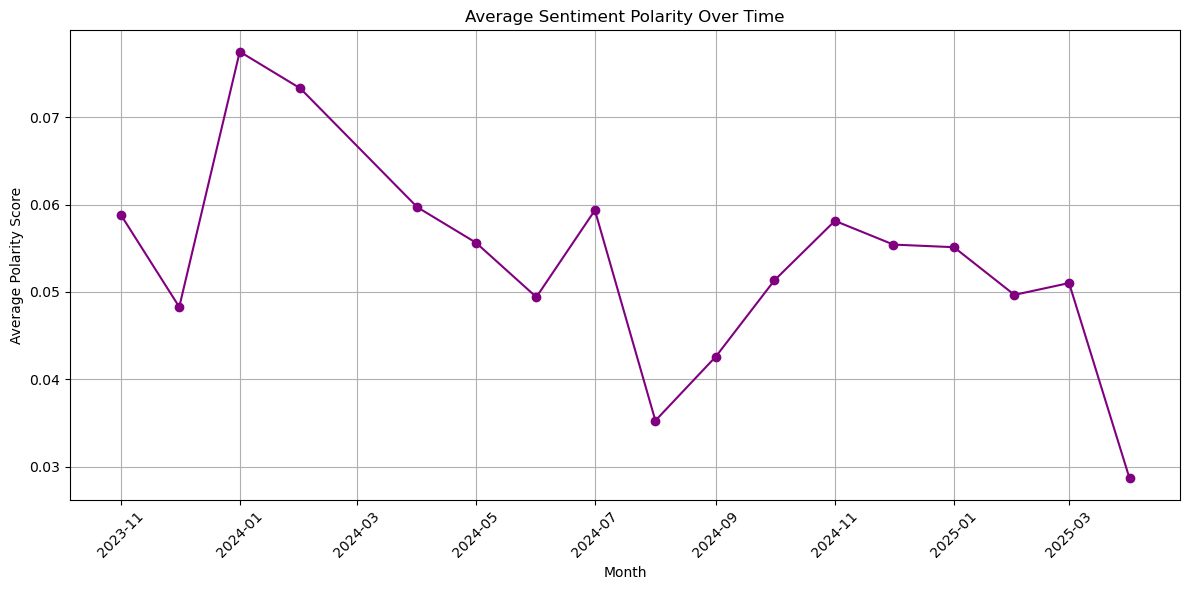

In [21]:
# Group by month
monthly_sentiment = df.groupby(df['Date'].dt.to_period('M')).agg({'polarity_score': 'mean'}).reset_index()
monthly_sentiment['Date'] = monthly_sentiment['Date'].dt.to_timestamp()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment['Date'], monthly_sentiment['polarity_score'], marker='o', linestyle='-', color='purple')
plt.title('Average Sentiment Polarity Over Time')
plt.xlabel('Month')
plt.ylabel('Average Polarity Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


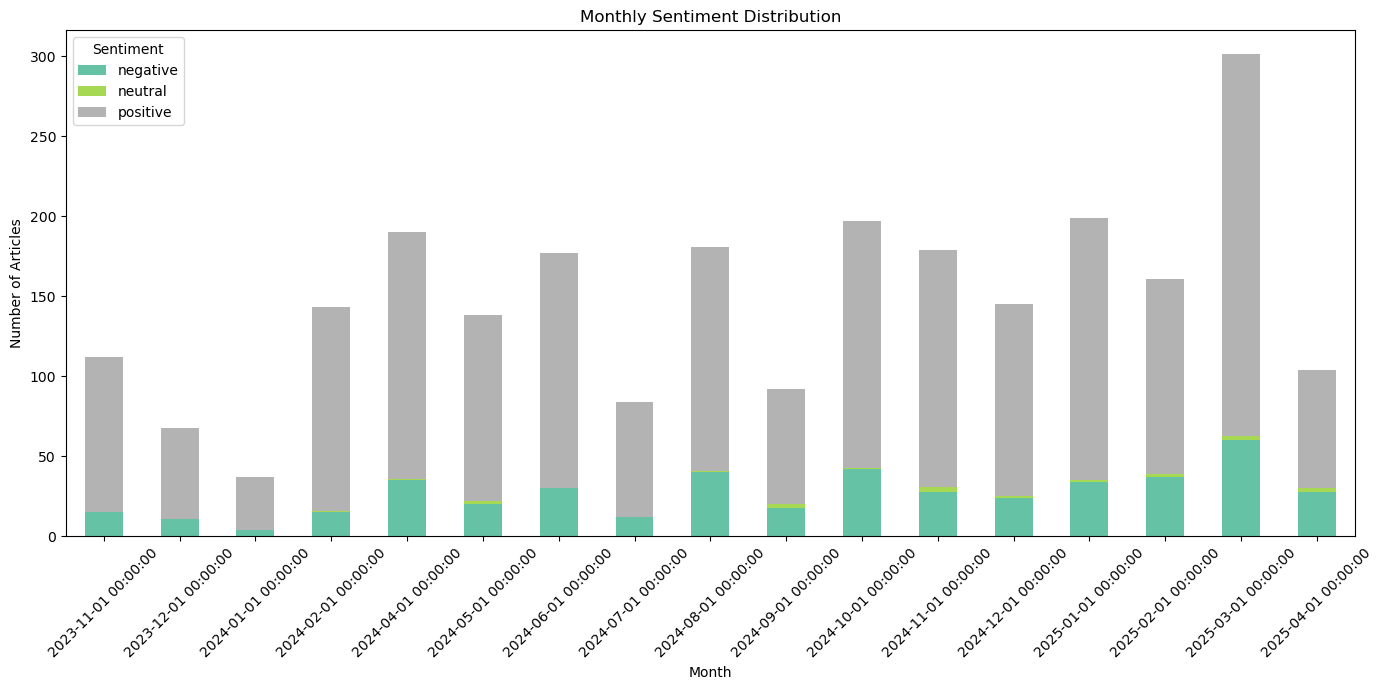

In [22]:
# Group and count by month & sentiment
monthly_counts = df.groupby([df['Date'].dt.to_period('M'), 'sentiment']).size().unstack(fill_value=0)
monthly_counts.index = monthly_counts.index.to_timestamp()

# Plot
monthly_counts.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='Set2')
plt.title('Monthly Sentiment Distribution')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
!pip install wordcloud


In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


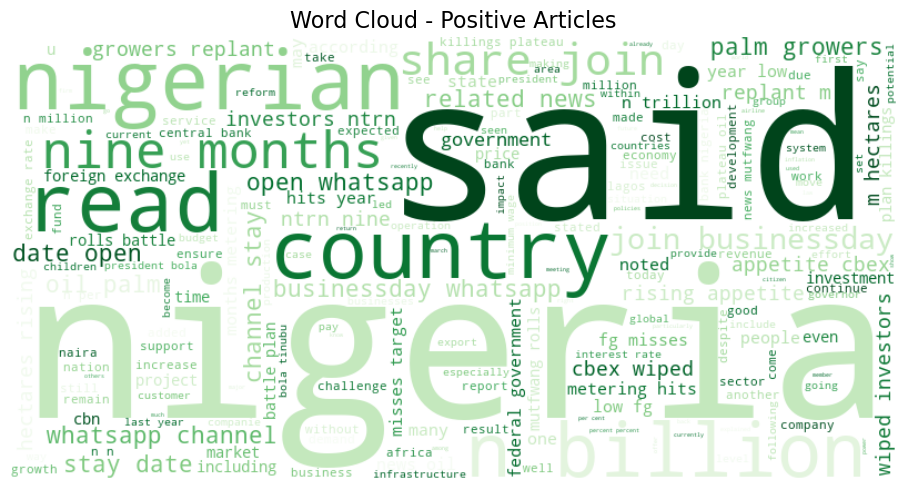

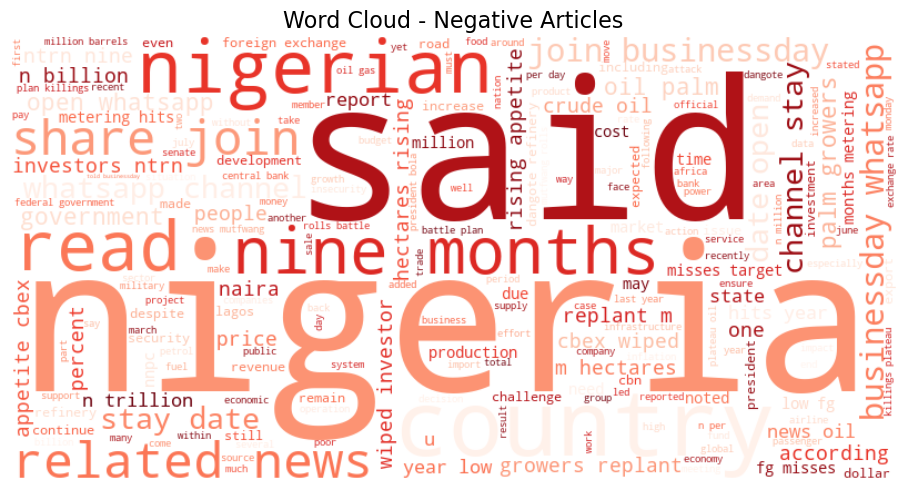

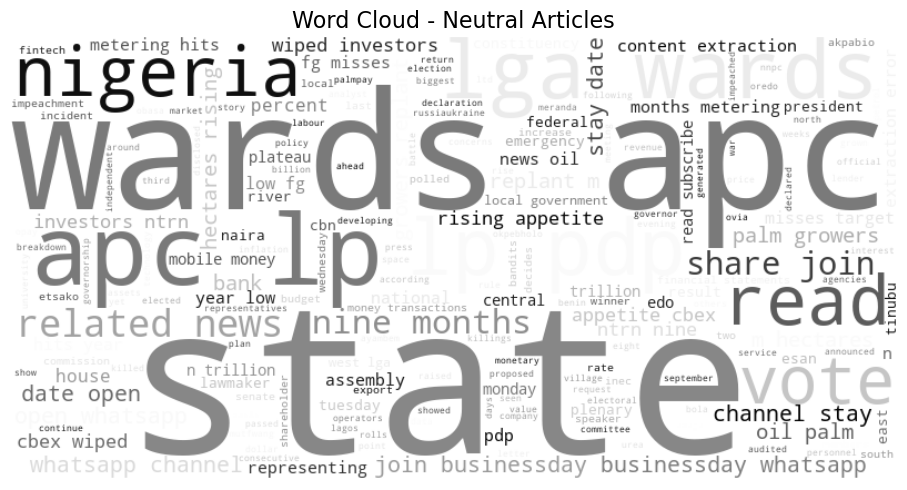

In [25]:
# Combine text for each sentiment
positive_text = " ".join(df[df['sentiment'] == 'positive']['cleaned_text'].dropna())
negative_text = " ".join(df[df['sentiment'] == 'negative']['cleaned_text'].dropna())
neutral_text = " ".join(df[df['sentiment'] == 'neutral']['cleaned_text'].dropna())

# WordCloud function
def plot_wordcloud(text, title, color):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate word clouds
plot_wordcloud(positive_text, 'Word Cloud - Positive Articles', 'Greens')
plot_wordcloud(negative_text, 'Word Cloud - Negative Articles', 'Reds')
plot_wordcloud(neutral_text, 'Word Cloud - Neutral Articles', 'Greys')


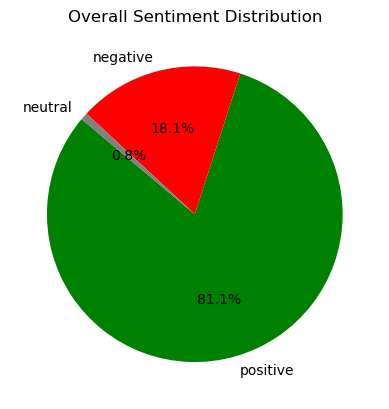

In [26]:
# Pie chart of sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
colors = ['green', 'red', 'grey']

sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Overall Sentiment Distribution')
plt.ylabel('')
plt.show()


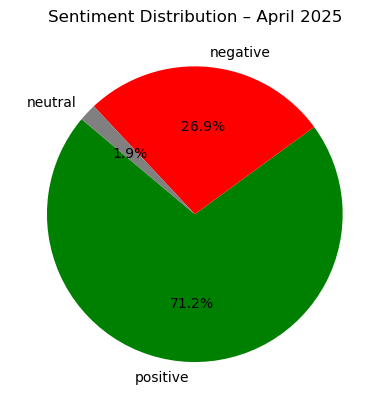

In [27]:
# Filter by month
month_df = df[df['Date'].dt.to_period('M') == '2025-04']

# Pie chart for that month
month_counts = month_df['sentiment'].value_counts()
month_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Sentiment Distribution – April 2025')
plt.ylabel('')
plt.show()


In [28]:
df.to_csv('businessday_sentiment_analysis.csv', index=False)


In [29]:
import os
os.getcwd()


'C:\\Users\\DELL LATITUDE 7399'